#### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from utils.print_utils import *
from utils.model_utils import *
from utils.interpol_utils import *
from utils.optimization_utils import *
from utils.data_utils import *


#### Synthetic Option

In [2]:
# Constants
r_ = 0.05
sigma_ = 0.4
K_ = 105
T_ = 1.

timesteps = 110
spacesteps =  80

# Monte Carlo simulation
x = np.linspace(.1, K_*3, spacesteps)
t = np.linspace(0, T_, timesteps)

dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Calculate 'tal' using vectorized operations
tal = (np.max(t) - T)

# Calculate the call prices using vectorized operations
call_prices = black_scholes_call(X, K_, tal, r_, sigma_)

# u is the call_prices array
u = call_prices.T

u_t = black_scholes_call_time_(X, K_, tal, r_, sigma_).T[:,:-1]

d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:33: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:34: RuntimeWarning: divide by zero encountered in true_divide
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:25: RuntimeWarning: divide by zero encountered in true_divide
  d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:26: RuntimeWarning: divide by zero encountered in true_divide
  call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S * ((sigma)/(2*np.sqrt(T))) * norm.pdf(d1)
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:26: RuntimeWarning: invalid value encountered in multiply
  call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S *

Error for Finite Difference 
RSE 2.2683591125444246e-06
RMSE 0.6985114685065918
Error for Numerical Black-Scholes
RSE 2.3638644525092834e-06
RMSE 0.7130646725084419


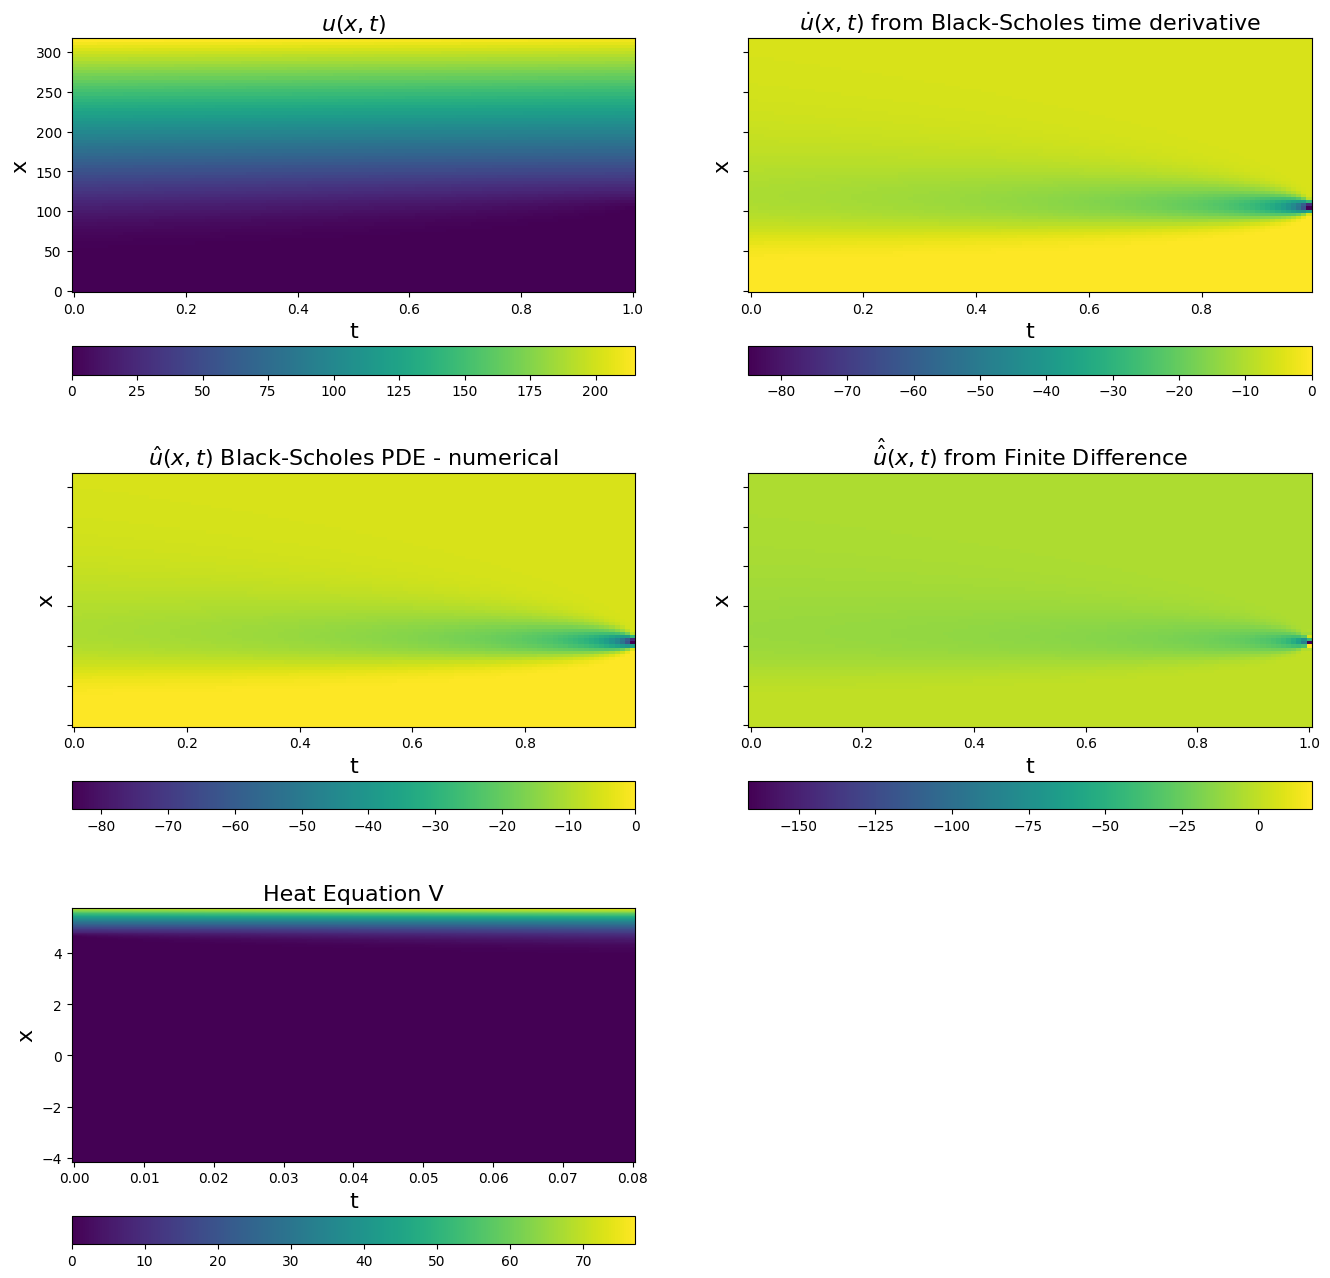

In [6]:
# n_arr = np.asarray([np.arange(0,spacesteps,1)]*timesteps).T
u_x = ps.FiniteDifference(axis=0,order = 6)._differentiate(u,t = dx)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 8)._differentiate(u,t = dx)
u_t_ = ps.FiniteDifference(axis=1,order = 25)._differentiate(u,t = dt)
# v_dot = numerical_partial_black_scholes(u.T,r,sigma).T


# Plot u and u_dot
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

# plt.subplot(3, 2, 5)
# plt.pcolormesh(t_[:,0], x_[0], v.T)
# plt.xlabel("t", fontsize=16)
# plt.ylabel("x", fontsize=16)
# ax = plt.gca()
# plt.title(r"Heat Equation V", fontsize=16)
# plt.colorbar(orientation="horizontal")

u_dot = -(1/2)*((sigma_**2)*(X.T[:,:-1]**2)*u_xx[:,:-1]) - (r_*(X.T[:,:-1])*u_x[:,:-1]) + r_*u[:,:-1]
plt.subplot(3, 2, 3)
plt.pcolormesh(t[:-1], x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{u}(x, t)$ Black-Scholes PDE - numerical", fontsize=16)
plt.colorbar(orientation="horizontal")


plt.subplot(3, 2, 4)
plt.pcolormesh(t, x, u_t_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{\hat{u}}(x, t)$ from Finite Difference", fontsize=16)
plt.colorbar(orientation="horizontal")

plt.subplot(3, 2, 2)
plt.pcolormesh(t[:-1], x, u_t)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from Black-Scholes time derivative", fontsize=16)
plt.colorbar(orientation="horizontal")


# print('Error for DURA-MOS¸NEAGU Computation')
# print('RSE',np.sum((u_t - v_dot)**2)/np.sum((u_t - u_t.mean())**2))
# print('RMSE',(np.sqrt(np.sum((u_t - v_dot)**2).mean())))
print('Error for Finite Difference ')
print('RSE',np.sum((u_t_[:,:-1] - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_t - u_t_[:,:-1])**2).mean())))
print('Error for Numerical Black-Scholes')
print('RSE',np.sum((u_dot - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_dot - u_t)**2).mean())))

plt.show()

##### PySINDy

In [7]:
u_reshaped = np.reshape(u, (len(x), len(t), 1))
u_dot  = np.reshape(u_dot, (*u_dot.shape, 1))
u_t  = np.reshape(u_t, (*u_t.shape, 1))
u_t_  = np.reshape(u_t_, (*u_t_.shape, 1))

# v_dot  = np.reshape(v_dot, (len(x), len(t), 1))
spatial_grid = np.reshape(X.T, (*X.T.shape, 1))

library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
    periodic=True # uniformly sampled in time
)

#Create Library with partial derivatives and spatial variable plus cross-terms
u_final = pde_lib.fit_transform(u_reshaped)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=2)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
lib_tr = lib.fit_transform(u_final)

In [8]:
# Add boundary conditional on T time of the derivative
# Create a new shape by adding 1 to the second dimension
original_shape = u_t.shape
new_shape = list(original_shape)
new_shape[1] += 1

_u_t = np.zeros(new_shape)
# Copy the original data into the new array up to the last layer

_u_t[:, :original_shape[1], :] = u_t



print('----------------------------Finite Difference--------------------------------')
#Fit the data using the finite difference approximation

print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=5e-3, alpha=2e3)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_t_)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = lib_tr[:,:-1,:] @ model.coefficients()[0]
print('R2',model.score(x = u_final,x_dot = _u_t))
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr,model.coefficients()[0],threshold = 0.1,axis=2,target = u_t_)
pred = lib_tr[:,:-1,:] @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))

print('*'*50)

----------------------------Finite Difference--------------------------------
STLSQ Regression
(x0)' = 0.048 u + -0.049 u_x*x + -0.081 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.8609541906339977
RSE 0.0003378739888405103
RMSE 8.525012318814943

Mean threshold remove 

u_t = + 0.05 u + -0.05 u_x*x + -0.08 u_xx*x^2
Error Model prediction against analytical solution:
RSE 0.0003378739888405103
RMSE 8.525012318814943
**************************************************


In [44]:
print('----------------------------Weak Formulation--------------------------------')


library_functions = [lambda x: x, lambda x: x * x,lambda x: X.T,lambda x: X.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']


pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    periodic=False,
    p = 8,
    differentiation_method = ps.FiniteDifference,
    K=500,
)


optimizer = ps.STLSQ(threshold=1e-2, alpha=1e2)

model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)
model.fit(u_reshaped)
model.print()
lib_weak = np.concatenate((lib_tr[:,:,:7],lib_tr[:,:,8:]),axis=2)
pred = lib_weak @ model.coefficients()[0]
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

coef = np.ravel(model.coefficients())
u_t_reshape = np.reshape(_u_t,(_u_t.shape[0],_u_t.shape[1],1))


# print('\nMean threshold remove \n')

# #Remove less participative terms
# new_coef = threshold_remove(lib_weak,coef,threshold = 0.01,axis=2,target = u_t_)
# pred = lib_weak @ new_coef

# print_model(new_coef,model.get_feature_names(),precision=3)
# print('Error Model prediction against analytical solution:')
# print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
# print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2))).mean())



----------------------------Weak Formulation--------------------------------
(u)' = 0.051 u + -0.002 uu_1 + -0.049 xu_1 + -0.080 x**2u_11
Error Model prediction against analytical solution:
RSE 37573983347.409706
RMSE 90525409.0580949


In [10]:

print('----------------------------Ensemble method----------------------------')
optimizer = ps.STLSQ(threshold=1e-2, alpha=1e0)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final, x_dot = u_t_,
        library_ensemble =False,
        ensemble = True,
        n_candidates_to_drop=5,
        n_models = 300,
        n_subset = len(t) // 2,
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print('Mean:')
print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print('Median:')
print_model(median_ensemble,lib.get_feature_names(),precision=3)
#Fit the data using ensemble methos on the finite difference values

print('Error Model prediction against analytical solution:')
optimizer.coef_ = median_ensemble
pred = lib_tr @ median_ensemble
print('R2',model.score(x = u_final[:,:-1,:],x_dot = u_t))
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr,median_ensemble,target = u_t_,threshold = 0.1,axis=2)
pred = lib_tr[:,:-1,:] @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))


----------------------------Ensemble method----------------------------
Mean:
u_t = + 0.031 u + -0.046 u_x + -0.0 u_xx + 0.0 x + 0.015 u*u_x + -0.011 u*u_xx + 0.0 u_x*u_xx + -0.048 u_x*x + 0.033 u_xx*x + -0.081 u_xx*x^2
Median:
u_t = + 0.05 u + -0.05 u_x*x + -0.08 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.9996621260111594
RSE 0.13753736527274393
RMSE 173.19574846547656

Mean threshold remove 

u_t = + 0.05 u + -0.05 u_x*x + -0.08 u_xx*x^2
Error Model prediction against analytical solution:
RSE 0.0003378739888405103
RMSE 8.525012318814943


##### Subsampling

In [11]:
num_points_to_sample = timesteps

# Generate random indices
random_rows = np.random.choice(u.shape[0], num_points_to_sample, replace=True)
# random_columns = np.concatenate(([0,-1],np.random.choice(u.shape[1], num_points_to_sample-2, replace=False)))

# Subsample the matrix
subsampled_u = np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
subsampled_x = x[random_rows]
subsampled_t = t

##### Interpolating for more points

In [12]:
interpol_dict = {

    'Cubic Spline': cubic_spline_interpolation, #Assumes regular grid
    'Smoothed Spline': smooth_spline_interpolation, # Good for noisy data
    'Linear': linear_interpolation,#Assumes regular grid
    'Bilinear':bilinear_interpolation, #Best for unstructured grid
    'Bicubic': bicubic_interpolation,#Best for unstructured grid
    'Rbf': rbf_interpolation,
    'Kriging': kriging_interpolation, #Good with very few points
    'IDW': idw_interpolation
}


Interpolation error for Original u
RSE: 0.0011518572715602904
RMSE: 25.070055572714786


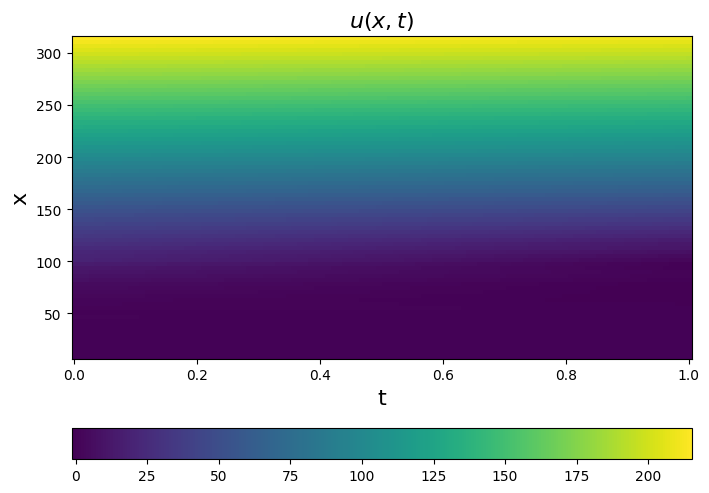

In [13]:
#Looking for the quality of interpolation
interpolation_method = 'Rbf'

n_time_points = 110
n_space_points =  80

interpol_u,ti,xi = interpol_dict[interpolation_method](subsampled_u,subsampled_t,subsampled_x,n_time_points,n_space_points)

xi = xi[:,0]
ti = ti[0,:]
Xi, Ti = np.meshgrid(xi, ti)
XTi = np.asarray([Xi, Ti]).T


# Plot u and u_dot
plt.figure(figsize=(8, 6))
plt.pcolormesh(ti, xi, interpol_u)
# plt.plot(xi,ti)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

#Error rate, interpoalte only in known points
interpol_u_test,_,_ = interpol_dict[interpolation_method](subsampled_u,subsampled_t,subsampled_x,timesteps,spacesteps)
rse, rmse = calc_error(interpol_u_test,u)

In [14]:
interpol_u_x = ps.FiniteDifference(axis=0,order = 7)._differentiate(interpol_u,t = xi)
interpol_u_xx = ps.FiniteDifference(axis=0,d=2,order = 2)._differentiate(interpol_u,t = xi)
interpol_u_t = ps.FiniteDifference(axis=1,order = 4)._differentiate(interpol_u,t = ti)

#Get indices of original subsampled 


final_indices = random_rows

interpol_u_ = np.ravel(interpol_u[final_indices,np.linspace(0,timesteps-1,timesteps,dtype=int)])
interpol_u_x_ = np.ravel(interpol_u_x[final_indices,np.linspace(0,timesteps-1,timesteps,dtype=int)])
interpol_u_xx_ =  np.ravel(interpol_u_xx[final_indices,np.linspace(0,timesteps-1,timesteps,dtype=int)])
interpol_u_t_ =  np.ravel(interpol_u_t[final_indices[:-1],np.linspace(0,timesteps-2,timesteps-1,dtype=int)])

_u =  np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
_u_x =  np.ravel(u_x[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
_u_xx =  np.ravel(u_xx[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
flatten_u_t =  np.ravel(u_t[random_rows[:-1],np.linspace(0,timesteps-2,timesteps-1,dtype=int),0])


try: #In case we interpolate for a bigger grid than the original supress the error
    print('Derivative approx through interpolation general error:')

    print('error u_x:',np.linalg.norm(interpol_u_x - u_x)/np.linalg.norm(u_x))
    print('error u_xx:',np.linalg.norm(interpol_u_xx - u_xx)/np.linalg.norm(u_xx))
    print('error u_t:',np.linalg.norm(interpol_u_t - u_t_[:,:,0])/np.linalg.norm(u_t_[:,:,0]))
except:
    print('Unmatched grid')
    pass

print('\n')


print('Derivative approx through interpolation sample error:')

print('error u:',np.linalg.norm(interpol_u_ - _u)/np.linalg.norm(_u))
print('error u_x:',np.linalg.norm(interpol_u_x_ - _u_x)/np.linalg.norm(_u_x))
print('error u_xx:',np.linalg.norm(interpol_u_xx_ - _u_xx)/np.linalg.norm(_u_xx))
print('error u_t:',np.linalg.norm(interpol_u_t_ - flatten_u_t)/np.linalg.norm(flatten_u_t))

Derivative approx through interpolation general error:
error u_x: 0.11717351214580357
error u_xx: 4.625704937173438
error u_t: 0.3821546172010298


Derivative approx through interpolation sample error:
error u: 0.022910452077099182
error u_x: 0.13018077491528074
error u_xx: 5.121596207037009
error u_t: 0.2850289037907481


In [15]:
print('-'*100)

interpol_u_t_reshape = np.reshape(interpol_u_t,(interpol_u_t.shape[0],interpol_u_t.shape[1],1))
interpol_u = interpol_u.reshape(interpol_u.shape[0],interpol_u.shape[1],1)

optimizer = ps.STLSQ(threshold=1e-3, alpha=1e1)

print('------------Finite Difference------------')
#Fit the data using the finite difference approximation
library_functions = [lambda x: x, lambda x: x * x,lambda x: Xi.T,lambda x: Xi.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = True,
    derivative_order=2,
    spatial_grid=xi,
    include_bias=False,
    is_uniform=False,
    differentiation_method = ps.SmoothedFiniteDifference,
    periodic=False # uniformly sampled in time
)
model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)

model.fit(interpol_u)
fit_lib = pde_lib.fit_transform(interpol_u)
model.print()


print('\nMean threshold remove \n')

#Remove less participative terms
new_coef = threshold_remove(fit_lib,coef,threshold = 0.25,axis=2,target = interpol_u_t_reshape)
pred = fit_lib[:,:-1,:] @ new_coef

print_model(new_coef,model.get_feature_names(),precision=3)
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2))).mean())

# print('Approximation error for real u:',model.score(u))
print('------------Weak Formulation------------')

optimizer = ps.STLSQ(threshold=2e-2, alpha=1e3)

library_functions = [lambda x: x, lambda x: x * x,lambda x: Xi.T,lambda x: Xi.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XTi,
    is_uniform=True,
    periodic=False,
    p = 7,
    differentiation_method = ps.SmoothedFiniteDifference,
    K=500,
)
model = ps.SINDy(feature_names = ['u'],feature_library=weak_lib, optimizer=optimizer)
model.fit(interpol_u)
model.print()

coef = np.ravel(model.coefficients())
fit_lib = pde_lib.fit_transform(interpol_u)


print('\nMean threshold remove \n')

#Remove less participative terms
new_coef = threshold_remove(fit_lib,coef,threshold = 0.25,axis=2,target = interpol_u_t_reshape)
pred = fit_lib[:,:-1,:] @ new_coef

print_model(new_coef,model.get_feature_names(),precision=3)
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2))).mean())


print('------------Ensemble------------')
optimizer = ps.STLSQ(threshold=1.5e-2, alpha=1e2)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_names = ['u'],feature_library=weak_lib, optimizer=optimizer)
model.fit(interpol_u,
        library_ensemble =False,
        ensemble = True,
        n_candidates_to_drop=2,
        n_models = 500,
        # n_subset = len(t),
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print_model(median_ensemble,lib.get_feature_names(),precision=3)

print('\nMean threshold remove \n')

#Remove less participative terms
new_coef = threshold_remove(fit_lib,median_ensemble,threshold = 0.1,axis=2,target = interpol_u_t_reshape)
pred = fit_lib[:,:-1,:] @ new_coef

print_model(new_coef,model.get_feature_names(),precision=3)
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2))).mean())





----------------------------------------------------------------------------------------------------
------------Finite Difference------------
(u)' = -0.006 u + -0.092 u_1 + 0.006 uu_1 + 0.073 uu_11 + -0.032 xu_11

Mean threshold remove 

u_t = + -0.042 u + -0.031 x**2u_11
Error Model prediction against analytical solution:
RSE 1.220395302764817
RMSE 512.3513671789423
------------Weak Formulation------------
(u)' = -0.503 u + -0.034 x + 0.612 uu_1 + -0.051 xu_1 + 0.125 u*uu_11 + -0.036 x**2u_11

Mean threshold remove 

u_t = + -0.678 u + -0.081 x + 0.777 uu_1 + -0.006 x**2u_11
Error Model prediction against analytical solution:
RSE 0.4461447762467805
RMSE 309.7815453413218
------------Ensemble------------
u_t = + 0.015 u + -0.048 u_xx + 0.118 u*u_xx + -0.052 u*x^2 + 0.118 u_x*x^2 + -0.038 u_xx*x^2
u_t = + 0.018 u + -0.047 u_xx + 0.117 u*u_xx + -0.052 u*x^2 + 0.119 u_x*x^2 + -0.039 u_xx*x^2

Mean threshold remove 

u_t = + -0.634 u + -0.074 x + 0.722 uu_1 + 0.065 u*uu_11 + -0.017 x**2u_